In [168]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
pd.options.display.float_format = '{:.2f}'.format
import pandas as pd
import numpy as np
%matplotlib inline
plt.rcParams["axes.formatter.limits"] = (-5, 12)
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
from scipy import stats
import shap
import warnings
from matplotlib import style
style.use('dark_background')


In [169]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Tratamento dos dados

In [170]:
Dados_LDL = pd.read_excel('/home/stnog/Modelo_Boleto/Dados_LDL.xlsx')
Dados_Boleto_17h = pd.read_excel('/home/stnog/Modelo_Boleto/Dados_Boleto_17h.xlsx')
Contas_ativas = pd.read_excel('/home/stnog/Modelo_Boleto/Contas_Ativas.xlsx')
Dados_celcoin = pd.read_excel('/home/stnog/Modelo_Boleto/Dados_celcoin.xlsx')
boleto_in = pd.read_excel('/home/stnog/Modelo_Boleto/boleto_in.xlsx')

In [171]:
feriados = pd.read_csv('/home/stnog/Modelo_Boleto/Feriados.csv')
feriado=pd.to_datetime(feriados['Data'])
feriados=pd.to_datetime(feriados['Data']).astype('str').tolist()
dia_de_semana = pd.bdate_range('2021-01-01', '2037-12-31')
dia_de_semana = dia_de_semana.astype('str').tolist()
wDays = [x for x in dia_de_semana if x not in feriados ]

In [172]:
Dados_celcoin = Dados_celcoin.rename(columns={'dia': 'Dia'})
Dados_celcoin = Dados_celcoin.rename(columns={'qtd': 'qtd_celcoin'})
Dados_celcoin['Dia'] = pd.to_datetime(Dados_celcoin['Dia'])

In [173]:
boleto_in = boleto_in.rename(columns={'dia': 'Dia'})
boleto_in['Dia'] = pd.to_datetime(boleto_in['Dia'])

In [174]:
Contas_ativas = Contas_ativas.rename(columns={'dia': 'Dia'})
Contas_ativas['Dia'] = pd.to_datetime(Contas_ativas['Dia'])

In [175]:
Contas_ativas['weekday'] = pd.to_datetime(Contas_ativas['Dia']).dt.weekday


In [176]:
Contas_ativas = Contas_ativas[(Contas_ativas['weekday']!=6)&(Contas_ativas['weekday']!=5)].reset_index(drop=True)


In [177]:
Contas_ativas['Contas_D-1'] = Contas_ativas['contas_ativas'].shift(1)


In [178]:
Contas_ativas['feriado'] = np.where(Contas_ativas.Dia.isin(pd.to_datetime(feriados)), 1, 0)


In [179]:
Dados_Boleto_17h = Dados_Boleto_17h.rename(columns={'paid_at': 'Dia'})


In [180]:
Dados_Boleto_17h = pd.merge(Dados_Boleto_17h, Dados_celcoin, on='Dia', how='left')

In [181]:
Dados_Boleto_17h = pd.merge(Dados_Boleto_17h, boleto_in, on='Dia', how='left')

In [182]:
Dados_Boleto_17h = Dados_Boleto_17h.fillna(0)

In [183]:
Dados_Boleto_17h

,Dia,sum,count,valor_celcoin,qtd_celcoin,boleto_in,qtd_in
0,2021-01-01,777769.44,1134,0.00,0.00,87761.63,112
1,2021-01-02,1688196.95,3303,0.00,0.00,77268.90,118
2,2021-01-03,1149937.54,1904,0.00,0.00,47411.79,92
3,2021-01-04,30095294.37,35960,1330.00,3.00,901035.53,1436
4,2021-01-05,12722553.82,18050,0.00,0.00,934512.42,1315
...,...,...,...,...,...,...,...
587,2022-08-12,28267553.43,37632,0.00,0.00,3581281.89,2744
588,2022-08-13,7228940.96,11852,0.00,0.00,127449.39,192
589,2022-08-14,2095309.70,3104,0.00,0.00,41868.21,50
590,2022-08-15,1473718.02,1488,85447191.09,94550.00,5052784.88,4460


In [184]:
Dados_Boleto_17h['weekday'] = pd.to_datetime(Dados_Boleto_17h['Dia']).dt.weekday

In [185]:
Dados_Boleto_17h['ajuste_domingo_sum'] = Dados_Boleto_17h['sum'].shift(1)
Dados_Boleto_17h['ajuste_domingo_count'] = Dados_Boleto_17h['count'].shift(1)
Dados_Boleto_17h['ajuste_sab_sum'] = Dados_Boleto_17h['sum'].shift(2)
Dados_Boleto_17h['ajuste_sab_count'] = Dados_Boleto_17h['count'].shift(2)
Dados_Boleto_17h['ajuste_domingo_sum_celcoin'] = Dados_Boleto_17h['valor_celcoin'].shift(1)
Dados_Boleto_17h['ajuste_domingo_count_celcoin'] = Dados_Boleto_17h['qtd_celcoin'].shift(1)
Dados_Boleto_17h['ajuste_sab_sum_celcoin'] = Dados_Boleto_17h['valor_celcoin'].shift(2)
Dados_Boleto_17h['ajuste_sab_count_celcoin'] = Dados_Boleto_17h['qtd_celcoin'].shift(2)
Dados_Boleto_17h['ajuste_domingo_sum_in'] = Dados_Boleto_17h['boleto_in'].shift(1)
Dados_Boleto_17h['ajuste_domingo_count_in'] = Dados_Boleto_17h['qtd_in'].shift(1)
Dados_Boleto_17h['ajuste_sab_sum_in'] = Dados_Boleto_17h['boleto_in'].shift(2)
Dados_Boleto_17h['ajuste_sab_count_in'] = Dados_Boleto_17h['qtd_in'].shift(2)
Dados_Boleto_17h

,Dia,sum,count,valor_celcoin,qtd_celcoin,boleto_in,qtd_in,weekday,ajuste_domingo_sum,ajuste_domingo_count,ajuste_sab_sum,ajuste_sab_count,ajuste_domingo_sum_celcoin,ajuste_domingo_count_celcoin,ajuste_sab_sum_celcoin,ajuste_sab_count_celcoin,ajuste_domingo_sum_in,ajuste_domingo_count_in,ajuste_sab_sum_in,ajuste_sab_count_in
0,2021-01-01,777769.44,1134,0.00,0.00,87761.63,112,4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,2021-01-02,1688196.95,3303,0.00,0.00,77268.90,118,5,777769.44,1134.00,nan,nan,0.00,0.00,nan,nan,87761.63,112.00,nan,nan
2,2021-01-03,1149937.54,1904,0.00,0.00,47411.79,92,6,1688196.95,3303.00,777769.44,1134.00,0.00,0.00,0.00,0.00,77268.90,118.00,87761.63,112.00
3,2021-01-04,30095294.37,35960,1330.00,3.00,901035.53,1436,0,1149937.54,1904.00,1688196.95,3303.00,0.00,0.00,0.00,0.00,47411.79,92.00,77268.90,118.00
4,2021-01-05,12722553.82,18050,0.00,0.00,934512.42,1315,1,30095294.37,35960.00,1149937.54,1904.00,1330.00,3.00,0.00,0.00,901035.53,1436.00,47411.79,92.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,2022-08-12,28267553.43,37632,0.00,0.00,3581281.89,2744,4,19428825.86,26589.00,25596381.09,32553.00,9597881.34,14043.00,15154843.77,21441.00,2960651.21,2338.00,5208986.34,4625.00
588,2022-08-13,7228940.96,11852,0.00,0.00,127449.39,192,5,28267553.43,37632.00,19428825.86,26589.00,0.00,0.00,9597881.34,14043.00,3581281.89,2744.00,2960651.21,2338.00
589,2022-08-14,2095309.70,3104,0.00,0.00,41868.21,50,6,7228940.96,11852.00,28267553.43,37632.00,0.00,0.00,0.00,0.00,127449.39,192.00,3581281.89,2744.00
590,2022-08-15,1473718.02,1488,85447191.09,94550.00,5052784.88,4460,0,2095309.70,3104.00,7228940.96,11852.00,0.00,0.00,0.00,0.00,41868.21,50.00,127449.39,192.00


In [186]:
Dados_Boleto_17h['valor'] = np.where(Dados_Boleto_17h['weekday']==0, Dados_Boleto_17h['sum']+Dados_Boleto_17h['ajuste_domingo_sum']+Dados_Boleto_17h['ajuste_sab_sum'], Dados_Boleto_17h['sum'])
Dados_Boleto_17h['Qtd'] = np.where(Dados_Boleto_17h['weekday']==0, Dados_Boleto_17h['count']+Dados_Boleto_17h['ajuste_domingo_count']+Dados_Boleto_17h['ajuste_sab_count'], Dados_Boleto_17h['count'])

In [187]:
Dados_Boleto_17h['valor_celcoin'] = np.where(Dados_Boleto_17h['weekday']==0, Dados_Boleto_17h['valor_celcoin']+Dados_Boleto_17h['ajuste_domingo_sum_celcoin']+Dados_Boleto_17h['ajuste_sab_sum_celcoin'], Dados_Boleto_17h['valor_celcoin'])
Dados_Boleto_17h['qtd_celcoin'] = np.where(Dados_Boleto_17h['weekday']==0, Dados_Boleto_17h['qtd_celcoin']+Dados_Boleto_17h['ajuste_domingo_count_celcoin']+Dados_Boleto_17h['ajuste_sab_count_celcoin'], Dados_Boleto_17h['qtd_celcoin'])

In [188]:
Dados_Boleto_17h['boleto_in'] = np.where(Dados_Boleto_17h['weekday']==0, Dados_Boleto_17h['boleto_in']+Dados_Boleto_17h['ajuste_domingo_sum_in']+Dados_Boleto_17h['ajuste_sab_sum_in'], Dados_Boleto_17h['boleto_in'])
Dados_Boleto_17h['qtd_in'] = np.where(Dados_Boleto_17h['weekday']==0, Dados_Boleto_17h['qtd_in']+Dados_Boleto_17h['ajuste_domingo_count_in']+Dados_Boleto_17h['ajuste_sab_count_in'], Dados_Boleto_17h['qtd_in'])

In [189]:
Dados_Boleto_17h.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592 entries, 0 to 591
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Dia                           592 non-null    datetime64[ns]
 1   sum                           592 non-null    float64       
 2   count                         592 non-null    int64         
 3   valor_celcoin                 592 non-null    float64       
 4   qtd_celcoin                   592 non-null    float64       
 5   boleto_in                     592 non-null    float64       
 6   qtd_in                        592 non-null    float64       
 7   weekday                       592 non-null    int64         
 8   ajuste_domingo_sum            591 non-null    float64       
 9   ajuste_domingo_count          591 non-null    float64       
 10  ajuste_sab_sum                590 non-null    float64       
 11  ajuste_sab_count              59

In [190]:
Colunas_rem = ['sum','count','ajuste_domingo_sum','ajuste_domingo_count','ajuste_sab_sum','ajuste_sab_count', 'ajuste_domingo_sum_celcoin', 'ajuste_domingo_count_celcoin', 'ajuste_sab_sum_celcoin','ajuste_sab_count_celcoin', 'ajuste_domingo_sum_in', 'ajuste_domingo_count_in', 'ajuste_sab_sum_in','ajuste_sab_count_in']
Dados_Boleto_17h = Dados_Boleto_17h.drop(Colunas_rem, axis=1)

In [191]:
Dados_Boleto_17h = Dados_Boleto_17h[(Dados_Boleto_17h['weekday']!=6)&(Dados_Boleto_17h['weekday']!=5)].reset_index(drop=True)

In [192]:
Dados_Boleto_17h['feriado'] = np.where(Dados_Boleto_17h.Dia.isin(pd.to_datetime(feriados)), 1, 0)

In [193]:
Dados_Boleto_17h = Dados_Boleto_17h.sort_values('Dia')

In [194]:
def feriado(Dados_Boleto_17h):
    for i in Dados_Boleto_17h.index:
        if Dados_Boleto_17h['feriado'].loc[i] == 1:
            Dados_Boleto_17h['valor'].loc[i+1] = Dados_Boleto_17h['valor'].loc[i+1] + Dados_Boleto_17h['valor'].loc[i]
            Dados_Boleto_17h['Qtd'].loc[i+1] = Dados_Boleto_17h['Qtd'].loc[i+1] + Dados_Boleto_17h['Qtd'].loc[i]
            Dados_Boleto_17h['valor_celcoin'].loc[i+1] = Dados_Boleto_17h['valor_celcoin'].loc[i+1] + Dados_Boleto_17h['valor_celcoin'].loc[i]
            Dados_Boleto_17h['qtd_celcoin'].loc[i+1] = Dados_Boleto_17h['qtd_celcoin'].loc[i+1] + Dados_Boleto_17h['qtd_celcoin'].loc[i]
            Dados_Boleto_17h['boleto_in'].loc[i+1] = Dados_Boleto_17h['boleto_in'].loc[i+1] + Dados_Boleto_17h['boleto_in'].loc[i]
            Dados_Boleto_17h['qtd_in'].loc[i+1] = Dados_Boleto_17h['qtd_in'].loc[i+1] + Dados_Boleto_17h['qtd_in'].loc[i]
    return Dados_Boleto_17h

In [195]:
feriado(Dados_Boleto_17h)

,Dia,valor_celcoin,qtd_celcoin,boleto_in,qtd_in,weekday,valor,Qtd,feriado
0,2021-01-01,0.00,0.00,87761.63,112.00,4,777769.44,1134.00,1
1,2021-01-04,1330.00,3.00,1113477.85,1758.00,0,33711198.30,42301.00,0
2,2021-01-05,0.00,0.00,934512.42,1315.00,1,12722553.82,18050.00,0
3,2021-01-06,0.00,0.00,666456.48,1026.00,2,9358715.15,14317.00,0
4,2021-01-07,0.00,0.00,813588.80,1075.00,3,9006199.89,13511.00,0
...,...,...,...,...,...,...,...,...,...
417,2022-08-10,15154843.77,21441.00,5208986.34,4625.00,2,25596381.09,32553.00,0
418,2022-08-11,9597881.34,14043.00,2960651.21,2338.00,3,19428825.86,26589.00,0
419,2022-08-12,0.00,0.00,3581281.89,2744.00,4,28267553.43,37632.00,0
420,2022-08-15,85447191.09,94550.00,5222102.48,4702.00,0,10797968.68,16444.00,0


In [196]:
Dados_Boleto_17h = Dados_Boleto_17h[Dados_Boleto_17h['feriado'] != 1].reset_index(drop=True)

In [197]:
Dados_Boleto_17h['Previa_LDL_D-1'] = Dados_Boleto_17h['valor'].shift(1)
Dados_Boleto_17h['Qtd_Bol_Previa_D-1'] = Dados_Boleto_17h['Qtd'].shift(1)


In [198]:
Dados_Boleto_17h['valor_celcoin_D-1'] = Dados_Boleto_17h['valor_celcoin'].shift(1)
Dados_Boleto_17h['qtd_celcoin_D-1'] = Dados_Boleto_17h['qtd_celcoin'].shift(1)

In [199]:
Dados_Boleto_17h['boleto_in_D-1'] = Dados_Boleto_17h['boleto_in'].shift(1)
Dados_Boleto_17h['qtd_in_D-1'] = Dados_Boleto_17h['qtd_in'].shift(1)

In [200]:
Dados_Boleto_17h

,Dia,valor_celcoin,qtd_celcoin,boleto_in,qtd_in,weekday,valor,Qtd,feriado,Previa_LDL_D-1,Qtd_Bol_Previa_D-1,valor_celcoin_D-1,qtd_celcoin_D-1,boleto_in_D-1,qtd_in_D-1
0,2021-01-04,1330.00,3.00,1113477.85,1758.00,0,33711198.30,42301.00,0,nan,nan,nan,nan,nan,nan
1,2021-01-05,0.00,0.00,934512.42,1315.00,1,12722553.82,18050.00,0,33711198.30,42301.00,1330.00,3.00,1113477.85,1758.00
2,2021-01-06,0.00,0.00,666456.48,1026.00,2,9358715.15,14317.00,0,12722553.82,18050.00,0.00,0.00,934512.42,1315.00
3,2021-01-07,0.00,0.00,813588.80,1075.00,3,9006199.89,13511.00,0,9358715.15,14317.00,0.00,0.00,666456.48,1026.00
4,2021-01-08,0.00,0.00,686297.30,1031.00,4,8665800.74,12637.00,0,9006199.89,13511.00,0.00,0.00,813588.80,1075.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,2022-08-10,15154843.77,21441.00,5208986.34,4625.00,2,25596381.09,32553.00,0,20755232.26,27057.00,73246975.58,83954.00,4693022.70,4655.00
403,2022-08-11,9597881.34,14043.00,2960651.21,2338.00,3,19428825.86,26589.00,0,25596381.09,32553.00,15154843.77,21441.00,5208986.34,4625.00
404,2022-08-12,0.00,0.00,3581281.89,2744.00,4,28267553.43,37632.00,0,19428825.86,26589.00,9597881.34,14043.00,2960651.21,2338.00
405,2022-08-15,85447191.09,94550.00,5222102.48,4702.00,0,10797968.68,16444.00,0,28267553.43,37632.00,0.00,0.00,3581281.89,2744.00


In [201]:
Dados_LDL['Dia'] = pd.to_datetime(Dados_LDL['inserted_at']).dt.date
Dados_LDL = Dados_LDL.drop('inserted_at', axis=1)

In [202]:
Dados_LDL = Dados_LDL[Dados_LDL['valor_brl']!=0].reset_index(drop=True)
Dados_LDL['Dia'] = pd.to_datetime(Dados_LDL['Dia'])

In [203]:
Dados_join = pd.merge(Dados_LDL, Dados_Boleto_17h, on='Dia')

In [204]:
Dados_tratados = pd.merge(Dados_join, Contas_ativas, on='Dia')

In [205]:
col_del = ['feriado_x', 'feriado_y', 'weekday_x']
Dados_tratados = Dados_tratados.drop(col_del, axis=1)

In [206]:
## Dados_tratados['Previa_LDL_D-1'] = np.where(Dados_tratados['valor_brl'] != Dados_tratados['valor_brl'].min(), -Dados_tratados['Previa_LDL_D-1'], Dados_tratados['Previa_LDL_D-1'])
## Dados_tratados['valor_brl'] = np.where(Dados_tratados['valor_brl'] != Dados_tratados['valor_brl'].min(), -Dados_tratados['valor_brl'], Dados_tratados['valor_brl'])


In [207]:
Dados_tratados['mes'] = pd.to_datetime(Dados_tratados['Dia']).dt.month
Dados_tratados['ano'] = pd.to_datetime(Dados_tratados['Dia']).dt.year
Dados_tratados['trimestre'] = pd.to_datetime(Dados_tratados['Dia']).dt.quarter

In [208]:
Dados_tratados['inicio_mes'] = np.where(pd.to_datetime(Dados_tratados['Dia']).dt.day < 10, 1, 0)

In [209]:
Dados_tratados = Dados_tratados.sort_values('Dia', ascending=True).reset_index(drop=True)

In [210]:
Dados_tratados['proc_celcoin'] = np.where(Dados_tratados['Dia'] > pd.to_datetime('2022-05-17'), 1, 0)

In [211]:
base_treino = Dados_tratados[:380]

In [212]:
base_validacao = Dados_tratados[380:]

In [213]:
base_treino['LDL_anterior'] = base_treino['valor_brl'].shift(1)
base_treino['diff_LDLs'] = base_treino['valor_brl'].diff(1)
base_treino['mm_LDL'] = base_treino['valor_brl'].rolling(5).mean()

In [214]:
valor_min = base_treino[base_treino['valor_brl']==base_treino['valor_brl'].min()]
valor_min

,valor_brl,code,Dia,valor_celcoin,qtd_celcoin,boleto_in,qtd_in,valor,Qtd,Previa_LDL_D-1,...,weekday_y,Contas_D-1,mes,ano,trimestre,inicio_mes,proc_celcoin,LDL_anterior,diff_LDLs,mm_LDL
64,5327110.31,LDL0021,2021-04-07,0.00,0.00,1203411.65,1569.00,11799307.65,19187.00,4660611.03,...,2,123181.00,4,2021,2,1,0,45737494.94,-40410384.63,17559727.78


In [215]:
base_validacao['LDL_anterior'] = base_validacao['valor_brl'].shift(1)
base_validacao['diff_LDLs'] = base_validacao['valor_brl'].diff(1)
base_validacao['mm_LDL'] = base_validacao['valor_brl'].rolling(5).mean()

In [216]:
features_corr = ['valor_brl', 'Previa_LDL_D-1',
       'Qtd_Bol_Previa_D-1', 'weekday_y', 'Contas_D-1', 'mes',
       'ano', 'trimestre', 'inicio_mes', 'LDL_anterior', 'diff_LDLs',
       'mm_LDL', 'valor_celcoin_D-1', 'qtd_celcoin_D-1', 'proc_celcoin', 'boleto_in_D-1', 'qtd_in_D-1']

In [217]:
import seaborn as sns
cm = sns.light_palette('green', as_cmap = True)
base_treino[features_corr].corr().style.background_gradient(cmap = cm)

,valor_brl,Previa_LDL_D-1,Qtd_Bol_Previa_D-1,weekday_y,Contas_D-1,mes,ano,trimestre,inicio_mes,LDL_anterior,diff_LDLs,mm_LDL,valor_celcoin_D-1,qtd_celcoin_D-1,proc_celcoin,boleto_in_D-1,qtd_in_D-1
valor_brl,1.000000,0.930819,0.910896,-0.168554,0.403988,0.163331,0.171822,0.154529,0.045008,0.191875,0.635618,0.599318,-0.096420,-0.111241,-0.182917,0.543824,0.556425
Previa_LDL_D-1,0.930819,1.000000,0.984319,-0.151040,0.357341,0.174140,0.099187,0.177418,0.010597,0.199609,0.575102,0.597999,-0.216936,-0.233831,-0.302606,0.505715,0.545392
Qtd_Bol_Previa_D-1,0.910896,0.984319,1.000000,-0.112599,0.414289,0.218702,0.119062,0.224329,-0.011355,0.267824,0.506138,0.663877,-0.244860,-0.261973,-0.335403,0.510212,0.532306
weekday_y,-0.168554,-0.151040,-0.112599,1.000000,-0.065449,0.007799,-0.013343,0.011545,-0.000554,0.075548,-0.191354,0.003702,-0.108984,-0.101353,-0.010558,-0.121247,-0.160035
Contas_D-1,0.403988,0.357341,0.414289,-0.065449,1.000000,0.314886,0.624649,0.296275,-0.051413,0.294384,0.089593,0.578878,0.399696,0.405129,0.340466,0.602334,0.391530
mes,0.163331,0.174140,0.218702,0.007799,0.314886,1.000000,-0.407971,0.967488,0.024936,0.159670,0.004806,0.254524,0.013697,0.016151,0.034175,0.363533,0.316903
ano,0.171822,0.099187,0.119062,-0.013343,0.624649,-0.407971,1.000000,-0.408804,0.015849,0.170941,0.001613,0.304158,0.480044,0.492088,0.468979,0.338212,0.133283
trimestre,0.154529,0.177418,0.224329,0.011545,0.296275,0.967488,-0.408804,1.000000,0.024162,0.147621,0.006913,0.243736,-0.005150,-0.004600,0.000794,0.358298,0.331849
inicio_mes,0.045008,0.010597,-0.011355,-0.000554,-0.051413,0.024936,0.015849,0.024162,1.000000,0.036713,0.004986,-0.001072,-0.015018,-0.011785,0.020614,-0.026196,-0.007149
LDL_anterior,0.191875,0.199609,0.267824,0.075548,0.294384,0.159670,0.170941,0.147621,0.036713,1.000000,-0.635700,0.583848,-0.144525,-0.151145,-0.183791,0.100289,0.029386


In [218]:
def wmape(y_true, y_pred):
    y_true=np.array(y_true)
    y_pred=np.array(y_pred)
    
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

from sklearn.metrics import mean_absolute_error

from sklearn.metrics import mean_absolute_percentage_error

In [219]:
def evaluate_baseline(y_true, y_pred):
#     errors = abs(predictions - test_labels)
    wmape_w = wmape(y_true, y_pred)
    mape=mean_absolute_percentage_error(y_true, y_pred)
    MAE= mean_absolute_error(y_true, y_pred)
#     mape = 100 * np.mean(errors / test_labels)
#     accuracy = 100 - mape
    
    print('Model Performance')

    print(f'MAE: {MAE}')
    print(f'MAPE: {mape}')
    print(f'WMAPE: {wmape_w}')
    

In [220]:
def evaluate(model, xval, yval):
    predictions = model.predict(xval)
#     errors = abs(predictions - test_labels)
    wmape_w = wmape(predictions, base_validacao['valor_brl'])
    mape=mean_absolute_percentage_error(predictions, base_validacao['valor_brl'])
    MAE= mean_absolute_error(predictions, base_validacao['valor_brl'])
#     mape = 100 * np.mean(errors / test_labels)
#     accuracy = 100 - mape
    
    print('Model Performance')

    print(f'MAE: {MAE}')
    print(f'MAPE: {mape}')
    print(f'WMAPE: {wmape_w}')

In [221]:
features_top = ['Previa_LDL_D-1',
       'Qtd_Bol_Previa_D-1', 'weekday_y', 'Contas_D-1', 'mes',
       'ano', 'trimestre', 'inicio_mes', 'LDL_anterior', 'diff_LDLs',
       'mm_LDL', 'valor_celcoin_D-1', 'qtd_celcoin_D-1', 'proc_celcoin', 'boleto_in_D-1', 'qtd_in_D-1']

## Baselines

### Naive

In [222]:
previsao = base_treino['valor_brl'][base_treino['LDL_anterior'].notna()]
valor = base_treino['LDL_anterior'][base_treino['LDL_anterior'].notna()]

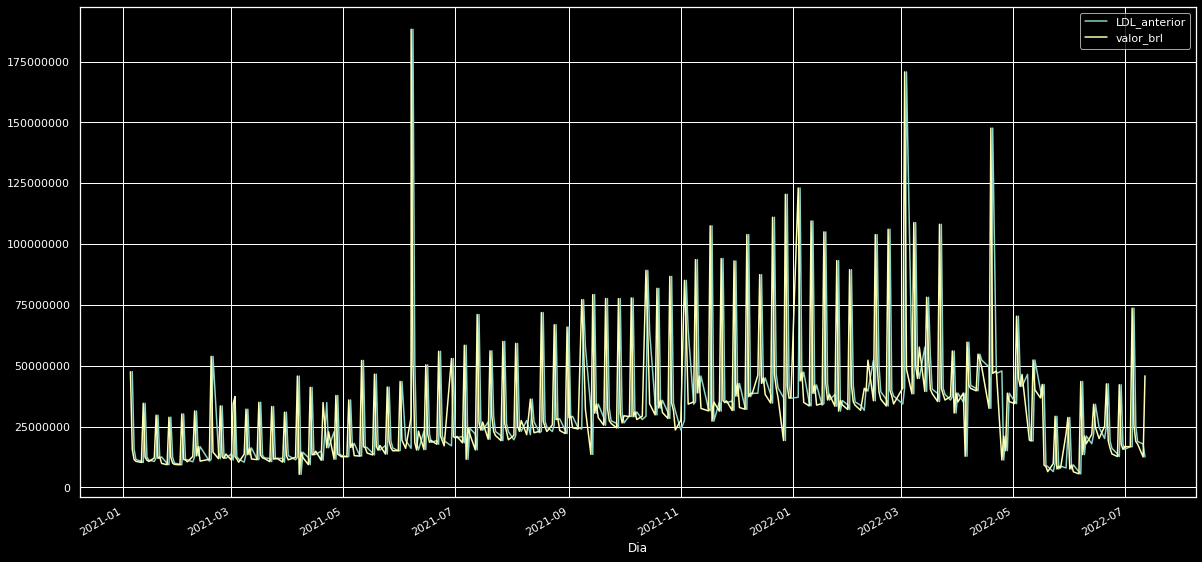

In [223]:
base_treino[['LDL_anterior','valor_brl']].set_index(pd.to_datetime(base_treino['Dia'])).plot(figsize=(20,10))

In [224]:
evaluate_baseline(valor,previsao)

Model Performance
MAE: 20009384.751635887
MAPE: 0.6676482862455352
WMAPE: 0.5866866034599013


### Moving Average

In [225]:
previsao = base_treino['valor_brl'][base_treino['mm_LDL'].notna()]
valor = base_treino['mm_LDL'][base_treino['mm_LDL'].notna()]

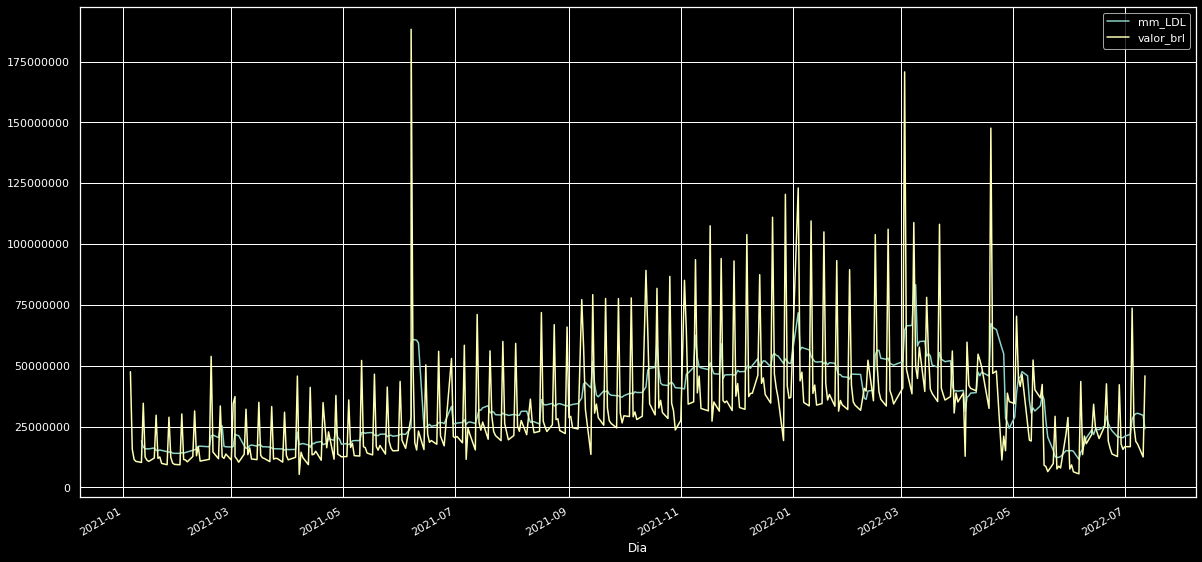

In [226]:
base_treino[['mm_LDL','valor_brl']].set_index(pd.to_datetime(base_treino['Dia'])).plot(figsize=(20,10))

In [227]:
evaluate_baseline(valor,previsao)

Model Performance
MAE: 14163107.535329785
MAPE: 0.4165641121384108
WMAPE: 0.41401264680086236


# Random Forest

In [228]:
imputer = SimpleImputer()
xtr=imputer.fit_transform(base_treino[features_top])
ytr=base_treino['valor_brl']

In [ ]:
model = RandomForestRegressor(n_estimators=10000, random_state=42, n_jobs=6)
model.fit(xtr, ytr)

In [ ]:
xval = imputer.fit_transform(base_validacao[features_top])
yval = base_validacao['valor_brl']
p = model.predict(xval)
base_validacao['previsao_LDL']= p[:]

In [ ]:
base_validacao[['valor_brl','previsao_LDL']].set_index(pd.to_datetime(base_validacao['Dia'])).plot(figsize=(20,10))

In [ ]:
evaluate(model, xval, yval)

### Hiperparametrização Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 10000, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt',0.5]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 3, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=1, n_jobs = -1)
rf_random.fit(xtr, ytr)

In [ ]:
rf_random.best_params_

In [ ]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, xval, base_validacao['valor_brl'])
print(random_accuracy)

In [ ]:
xval = imputer.fit_transform(base_validacao[features_top])
yval = base_validacao['valor_brl']
p_best_rf= best_random.predict(xval)
base_validacao['best_previsao_LDL']= p_best_rf[:]

In [ ]:
base_validacao[['valor_brl','best_previsao_LDL']].set_index(pd.to_datetime(base_validacao['Dia'])).plot(figsize=(20,10))

# XGBoost

In [229]:
xval = imputer.fit_transform(base_validacao[features_top])
yval = base_validacao['valor_brl']

In [230]:
xtr=imputer.fit_transform(base_treino[features_top])
ytr=base_treino['valor_brl']

In [231]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [232]:
reg = xgb.XGBRegressor(n_estimators=10000)

In [233]:
reg.fit(xtr, ytr,
        eval_set=[(xtr, ytr), (xval, yval)],
        early_stopping_rounds=50,
       verbose=False,) 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

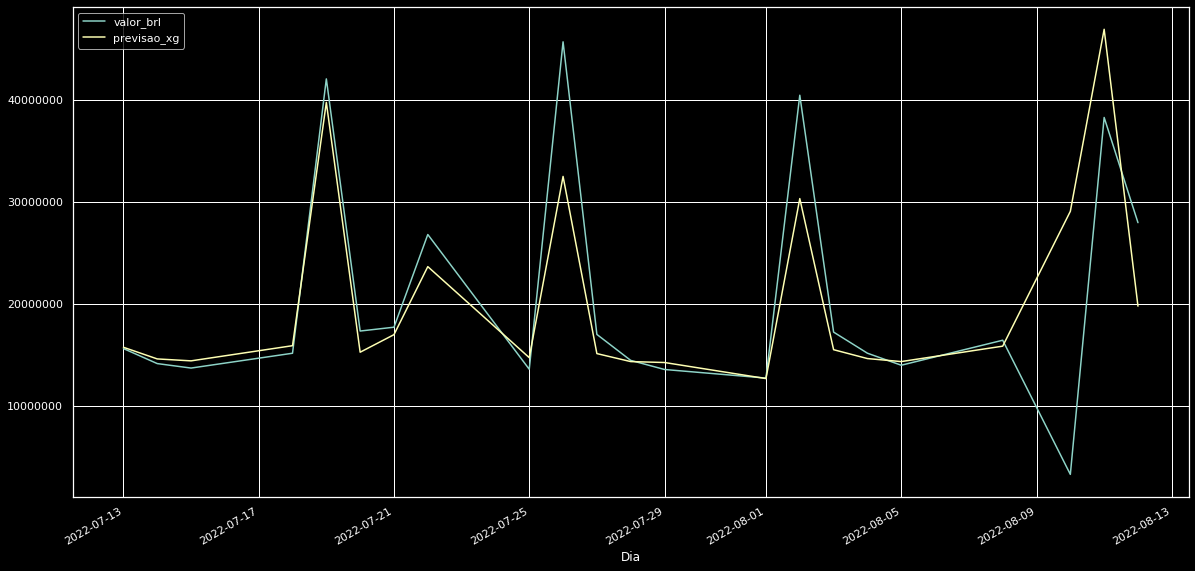

In [234]:
base_validacao['previsao_xg'] = reg.predict(xval)

base_validacao[['valor_brl','previsao_xg']].set_index(pd.to_datetime(base_validacao['Dia'])).plot(figsize=(20,10))

In [235]:
evaluate(reg,xval,yval)

Model Performance
MAE: 3782553.7581818183
MAPE: 0.14542938211927506
WMAPE: 0.18651808957912347


### Hiperparametrização XGBoost

In [236]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [237]:
space={'max_depth':  hp.choice('max_depth', np.arange(3, 19, dtype=int)),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 10000}

In [238]:
def hyperparameter_tuning(space):
    model=xgb.XGBRegressor(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                         reg_alpha = int(space['reg_alpha']),min_child_weight=space['min_child_weight'],
                         colsample_bytree=space['colsample_bytree'])
    
    evaluation = [( xtr, ytr), ( xval, yval)]
    
    model.fit(xtr, ytr,
            eval_set=evaluation,
            early_stopping_rounds=10,verbose=False)

    pred = model.predict(xval)
    wmape_w = wmape(pred, base_validacao['valor_brl'])
    mape=mean_absolute_percentage_error(pred, base_validacao['valor_brl'])
    MAE= mean_absolute_error(pred, base_validacao['valor_brl'])
#     mape = 100 * np.mean(errors / test_labels)
#     accuracy = 100 - mape
    #change the metric if you like
    return {'loss':wmape_w, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print (best)

100%|██████████| 100/100 [01:22<00:00,  1.21trial/s, best loss: 0.1162974432092233]
{'colsample_bytree': 0.6703420829606037, 'gamma': 2.3008852667035162, 'max_depth': 2, 'min_child_weight': 1.0, 'reg_alpha': 48.0, 'reg_lambda': 0.29081762229838726}


In [239]:
reg = xgb.XGBRegressor(n_estimators = 10000, colsample_bytree = best['colsample_bytree'], gamma = best['gamma'], max_depth = best['max_depth'], min_child_weight = best['min_child_weight'], reg_alpha = best['reg_alpha'], reg_lambda = best['reg_lambda'])

In [240]:
reg.fit(xtr, ytr,
        eval_set=[(xtr, ytr), (xval, yval)],
        early_stopping_rounds=50,
       verbose=False,) 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.6703420829606037, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=2.3008852667035162, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1.0,
             missing=nan, monotone_constraints='()', n_estimators=10000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=48.0, reg_lambda=0.29081762229838726, ...)

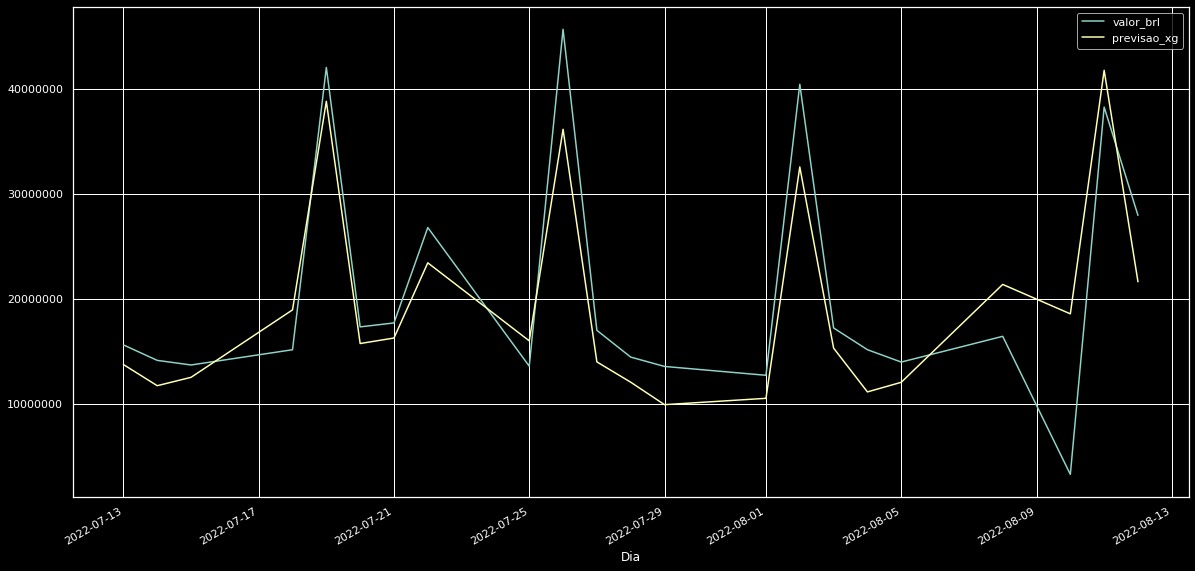

In [241]:
base_validacao['previsao_xg'] = reg.predict(xval)

base_validacao[['valor_brl','previsao_xg']].set_index(pd.to_datetime(base_validacao['Dia'])).plot(figsize=(20,10))

In [242]:
evaluate(reg, xval, yval)

Model Performance
MAE: 3990189.9954545456
MAPE: 0.21681322522707783
WMAPE: 0.20692189346250353


### Removendo Outlier

In [243]:
base_validacao = base_validacao[base_validacao['valor_brl']!= base_validacao['valor_brl'].min()]

In [244]:
xval = imputer.fit_transform(base_validacao[features_top])
yval = base_validacao['valor_brl']

In [245]:
reg = xgb.XGBRegressor(n_estimators = 10000, colsample_bytree = best['colsample_bytree'], gamma = best['gamma'], max_depth = best['max_depth'], min_child_weight = best['min_child_weight'], reg_alpha = best['reg_alpha'], reg_lambda = best['reg_lambda'])

In [246]:
reg.fit(xtr, ytr,
        eval_set=[(xtr, ytr), (xval, yval)],
        early_stopping_rounds=50,
       verbose=False,) 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.6703420829606037, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=2.3008852667035162, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1.0,
             missing=nan, monotone_constraints='()', n_estimators=10000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=48.0, reg_lambda=0.29081762229838726, ...)

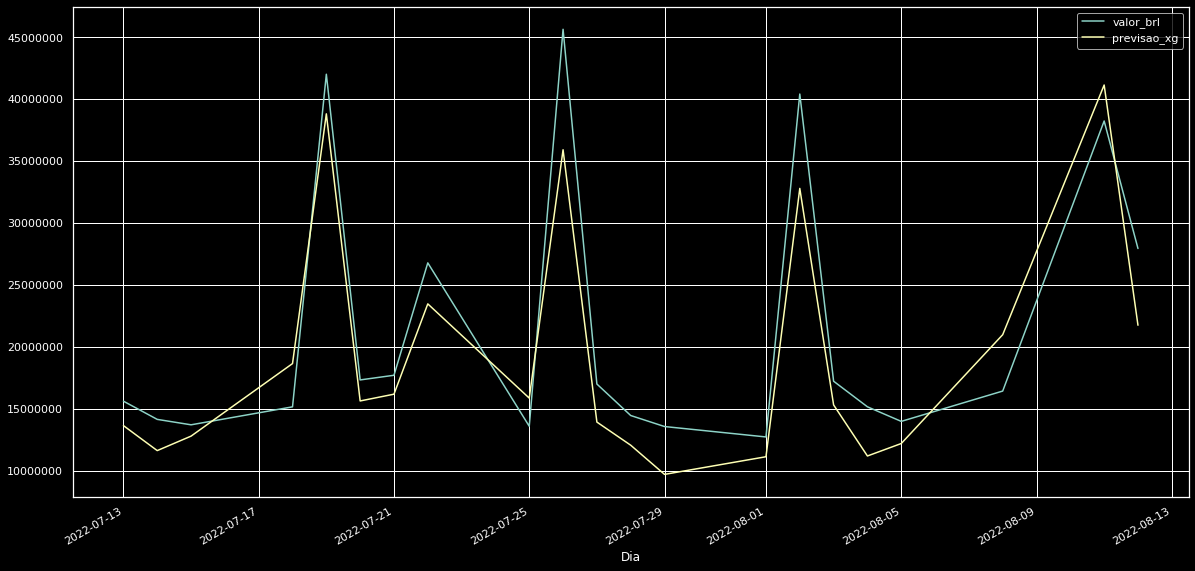

In [247]:
base_validacao['previsao_xg'] = reg.predict(xval)

base_validacao[['valor_brl','previsao_xg']].set_index(pd.to_datetime(base_validacao['Dia'])).plot(figsize=(20,10))

In [248]:
evaluate(reg,xval,yval)

Model Performance
MAE: 3359460.061904762
MAPE: 0.183602593264068
WMAPE: 0.1742883359694234


In [249]:
valor_max = base_validacao[base_validacao['valor_brl']==base_validacao['valor_brl'].max()]
valor_max

,valor_brl,code,Dia,valor_celcoin,qtd_celcoin,boleto_in,qtd_in,valor,Qtd,Previa_LDL_D-1,...,Contas_D-1,mes,ano,trimestre,inicio_mes,proc_celcoin,LDL_anterior,diff_LDLs,mm_LDL,previsao_xg
389,45657477.39,LDL0021,2022-07-26,25226433.87,33826.00,2479699.13,1882.00,6512116.56,8297.00,20691130.60,...,351778.00,7,2022,3,0,1,13587604.95,32069872.44,24213516.85,35925244.00
